# Imports


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from functools import partial
import logging
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from typing import *
import time
import yaml
from yaml import YAMLObject

import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras import losses
from tensorflow.keras import metrics as keras_metrics

from tomo2seg import slack
from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    MetaCrop3DGenerator, VolumeCropSequence,
    UniformGridPosition, SequentialGridPosition,
    ET3DUniformCuboidAlmostEverywhere, ET3DConstantEverywhere, 
    GTUniformEverywhere, GTConstantEverywhere, 
    VSConstantEverywhere, VSUniformEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg import callbacks as tomo2seg_callbacks
from tomo2seg import losses as tomo2seg_losses
from tomo2seg.schedule import ComposedSchedule, LogSpaceSchedule


# Setup


In [3]:
logger.setLevel(logging.DEBUG)

In [9]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())
# runid = 1607466349
logger.info(f"{runid=}")

INFO::tomo2seg::{<ipython-input-9-a53a2ef95cd6>:<module>:005}::[2020-12-09::17:37:01.903]
runid=1607466349



In [5]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
# strategy = tf.distribute.MirroredStrategy(devices=[""])  


DEBUG::tomo2seg::{<ipython-input-5-7a7728cf1275>:<module>:001}::[2020-12-09::17:35:47.759]
tf.__version__='2.2.0'

INFO::tomo2seg::{<ipython-input-5-7a7728cf1275>:<module>:002}::[2020-12-09::17:35:47.853]
Num GPUs Available: 2
This should be 2 on R790-TOMO.

DEBUG::tomo2seg::{<ipython-input-5-7a7728cf1275>:<module>:003}::[2020-12-09::17:35:48.235]
Both here should return 2 devices...
tf.config.list_physical_devices('GPU')=[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
tf.config.list_logical_devices('GPU')=[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

In [6]:
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
#     VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

INFO::tomo2seg::{<ipython-input-6-f863a788f16a>:<module>:010}::[2020-12-09::17:35:56.490]
volume_name='PA66GF30' volume_version='v1' labels_version='refined3'



In [7]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

n_classes = len(volume.metadata.labels)

def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=volume.metadata.dimensions,
        verbose=True,
    )

read_raw = partial(_read_raw, volume_=volume)

logger.info("Loading data from disk.")

## Data
voldata = read_raw(volume.data_path) / 255  # normalize
logger.debug(f"{voldata.shape=}")

voldata_train = volume.train_partition.get_volume_partition(voldata)
voldata_val = volume.val_partition.get_volume_partition(voldata)

logger.debug(f"{voldata_train.shape=}")
logger.debug(f"{voldata_val.shape=}")

del voldata

## Labels
vollabels = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{vollabels.shape=}")

vollabels_train = volume.train_partition.get_volume_partition(vollabels)
vollabels_val = volume.val_partition.get_volume_partition(vollabels)

logger.debug(f"{vollabels_train.shape=}")
logger.debug(f"{vollabels_val.shape=}")

del vollabels

DEBUG::tomo2seg::{data.py:with_check:258}::[2020-12-09::17:35:57.178]
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

DEBUG::tomo2seg::{data.py:metadata:195}::[2020-12-09::17:35:57.181]
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

INFO::tomo2seg::{<ipython-input-7-6e0649e4ec97>:<module>:007}::[2020-12-09::17:35:57.196]
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [0, 1300], 'alias': 'train'}, 'val': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [1600, 1900], 'alias': 'val'}, 'test': {'x_range': [0, 1300], 'y_range': [0, 1040], 'z_range': [1300, 1600], 'alias': 'test'}}))

INFO::tomo2seg::{<ipython-input-7-6e0649e4ec97>:<module>:024}::[2020-12-09::17:35:57.198]
Loading data from d

# Model

In [10]:
try:
    tomo2seg_model
except NameError:
    print("already deleted (:")
else:
    del tomo2seg_model

already deleted (:


In [11]:
# crop_shape = (256, 256, 1)  # multiple of 16 (requirement of a 4-level u-net)
# bigger crops will have less border effects (?)
crop_shape = (112, 112, 112, 1)  # multiple of 16 (requirement of a 4-level u-net)

model_master_name = "unet3d"
model_version = "crop112-f12"
model_factory_function = modular_unet.u_net
model_factory_kwargs = {
    **modular_unet.kwargs_vanilla03,
    **dict(
        convlayer=modular_unet.ConvLayer.conv3d,
        input_shape = crop_shape,
        output_channels=n_classes,
#         nb_filters_0 = 2,
#         nb_filters_0 = 4,
#         nb_filters_0 = 8,
        nb_filters_0 = 12,
#         nb_filters_0 = 16,
#         nb_filters_0 = 32,
    ),
}

In [12]:
try:
    tomo2seg_model
    
except NameError:
    logger.info("Creating a Tomo2SegModel.")
    
    tomo2seg_model = Tomo2SegModel(
        model_master_name, 
        model_version, 
        runid=runid,
        factory_function=model_factory_function,
        factory_kwargs=model_factory_kwargs,
    )
                
else:
    logger.warning("The model is already defined. To create a new one: `del tomo2seg_model`")

finally:
    
    logger.info(f"{tomo2seg_model=}")
    
logger.info("Creating the Keras model.")

with strategy.scope():
    if not tomo2seg_model.autosaved_model_path.exists():
        logger.info(f"Instantiating a new model with model_factory_function={model_factory_function.__name__}")
      
        model = model_factory_function(
            name=tomo2seg_model.name,
            **model_factory_kwargs
        )
    else:
        logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
        model = keras.models.load_model(tomo2seg_model.autosaved_model_path_str, compile=False)

    logger.info("Compiling the model.")

    # using the avg jaccard is dangerous if one of the classes is too
    # underrepresented because it's jaccard will be unstable
    loss = tomo2seg_losses.jaccard2_flat

    optimizer = optimizers.Adam(lr=.003)
    metrics = [
#         tomo2seg_losses.jaccard2_macro_avg,
#         keras_metrics.Accuracy(),
#     ] + [
#         tomo2seg_losses.Jaccard2(class_idx)
#         for class_idx in range(n_classes)
    ]

    model.compile(
        loss=loss, 
        optimizer=optimizer,
        metrics=metrics,
    )
    model.save(tomo2seg_model.model_path)

    # write the model summary in a file
    with tomo2seg_model.summary_path.open("w") as f:
        def print_to_txt(line):
            f.writelines([line + "\n"])
        model.summary(print_fn=print_to_txt, line_length=140)

    # same for the architecture
    utils.plot_model(model, show_shapes=True, to_file=tomo2seg_model.architecture_plot_path);

    logger.info(f"Check the summary and the figure of the model in the following locations:\n{tomo2seg_model.summary_path}\n{tomo2seg_model.architecture_plot_path}")

INFO::tomo2seg::{<ipython-input-12-2291d74903ed>:<module>:005}::[2020-12-09::17:37:31.845]
Creating a Tomo2SegModel.

INFO::tomo2seg::{<ipython-input-12-2291d74903ed>:<module>:020}::[2020-12-09::17:37:31.846]
tomo2seg_model=Model(master_name='unet3d', version='crop112-f12', fold=0, runid=1607466349, factory_function='tomo2seg.modular_unet.u_net', factory_kwargs={'depth': 4, 'sigma_noise': 0, 'updown_conv_sampling': True, 'unet_block_kwargs': {'kernel_size': 3, 'res': True, 'batch_norm': True, 'dropout': 0}, 'unet_down_kwargs': {'batchnorm': True}, 'unet_up_kwargs': {'batchnorm': True}, 'convlayer': <ConvLayer.conv3d: 10>, 'input_shape': (112, 112, 112, 1), 'output_channels': 3, 'nb_filters_0': 12})

INFO::tomo2seg::{<ipython-input-12-2291d74903ed>:<module>:022}::[2020-12-09::17:37:31.847]
Creating the Keras model.

An autosaved model already exists, loading it instead of creating a new one!

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job

# Data crop sequences

In [15]:
batch_size_per_replica = 1
batch_size = batch_size_per_replica * (n_replicas := strategy.num_replicas_in_sync)

common_random_state = 144  # i resumed the training so i changed this

logger.info(f"{batch_size_per_replica=}\n{n_replicas=}\n{batch_size=}\n{common_random_state=}\n{crop_shape=}")

INFO::tomo2seg::{<ipython-input-15-b6382cff3437>:<module>:006}::[2020-12-09::17:38:09.638]
batch_size_per_replica=1
n_replicas=2
batch_size=2
common_random_state=144
crop_shape=(112, 112, 112, 1)



## Train

In [16]:
data = voldata_train
labels = vollabels_train
volume_shape = data.shape
labels_list = volume.metadata.labels

crop_seq_train = VolumeCropSequence(
    data_volume=data,
    labels_volume=labels,
    labels=labels_list,
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape,
        crop_shape=crop_shape,
        x0y0z0_generator=(
            grid_pos_gen := UniformGridPosition.build_from_volume_crop_shapes(
                volume_shape=volume_shape, 
                crop_shape=crop_shape,
                random_state=RandomState(common_random_state),
            )
        ),
        # it is too slow to use this
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator=grid_pos_gen),
#         gt_field=GTUniformEverywhere.build_2d(
        gt_field=GTUniformEverywhere.build_3d(
            random_state=RandomState(common_random_state),
            grid_position_generator=grid_pos_gen,
        ),
        vs_field=VSUniformEverywhere.build_plus_or_mines(
            shift=1. / 255 / 2,  # half a value to both sides +/-
            grid_position_generator=grid_pos_gen,
            random_state=RandomState(common_random_state),
        ),
        is_2halfd=True,
    ),
    batch_size=batch_size,
    # this volume cropper only returns random crops, 
    #so the number of crops per epoch/batch is w/e i want
#     epoch_size=5,
    epoch_size=1,
    meta_crops_hist_path=tomo2seg_model.train_metacrop_history_path,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
#     output_as_2d=True,
#     output_as_2halfd=True,
)

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:438}::[2020-12-09::17:38:38.486]
Built UniformGridPosition from volume_shape=(1300, 1040, 1300) and crop_shape=(112, 112, 112, 1) ==> {'x_range': (0, 1189), 'y_range': (0, 929), 'z_range': (0, 1189)}

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:400}::[2020-12-09::17:38:38.488]
UniformGridPosition ==> npositions=1313346809 (1,313,346,809)

Initializing ET3DConstantEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing VSUniformEverywhere with a UniformGridPosition.
The {x, y, z}_range values will be overwritten.

DEBUG::tomo2seg::{volume_sequence.py:__post_init__:1353}::[2020-12-09::17:38:38.492]
Initializing VolumeCropSequence.



## Val

In [17]:
# val volume

data = voldata_val
labels = vollabels_val
volume_shape = data.shape
labels_list = volume.metadata.labels

crop_seq_val = VolumeCropSequence(
    # data source
    data_volume=data,
    labels_volume=labels,
    labels=labels_list,
    
    # data augmentation
    meta_crop_generator=MetaCrop3DGenerator(
        volume_shape=volume_shape,
        crop_shape=crop_shape,
        x0y0z0_generator=(
            grid_pos_gen := SequentialGridPosition.build_min_overlap(
                volume_shape=volume_shape, crop_shape=crop_shape,
                # reduce the total number of crops
#                 n_steps_x=15,
#                 n_steps_y=15,
                # increase the total number of crops
                n_steps_z=8,
            )
#             grid_pos_gen := SequentialGridPosition.build_from_volume_crop_shapes(
#                 volume_shape=volume_shape, crop_shape=crop_shape,
#                 n_steps_x=2, n_steps_y=2, n_steps_z=200,
#             )
        ),
        et_field=ET3DConstantEverywhere.build_no_displacement(grid_position_generator=grid_pos_gen),
#         gt_field=GTConstantEverywhere.build_gt2d_identity(grid_position_generator=grid_pos_gen),
        gt_field=GTConstantEverywhere.build_gt3d_identity(grid_position_generator=grid_pos_gen),
        vs_field=VSConstantEverywhere.build_no_shift(grid_position_generator=grid_pos_gen),
        is_2halfd=True,
    ),
    
    # others
    batch_size=batch_size,
    epoch_size=len(grid_pos_gen),  # go through all the crops in validation    
    meta_crops_hist_path=None,  # todo add a new path to the model and save this
    debug__no_data_check=True,  # remove me!
    
#     output_as_2d=True,
#     output_as_2halfd=True,
)

INFO::tomo2seg::{volume_sequence.py:build_min_overlap:506}::[2020-12-09::17:38:46.312]
Building SequentialGridPosition with minimal overlap (smallest n_steps in each directions) n_steps={'n_steps_x': 12, 'n_steps_y': 10, 'n_steps_z': 3}.

n_steps_kwargs={'n_steps_z': 8} was given --> effective n_steps={'n_steps_x': 12, 'n_steps_y': 10, 'n_steps_z': 8}

INFO::tomo2seg::{volume_sequence.py:build_from_volume_crop_shapes:438}::[2020-12-09::17:38:46.314]
Built SequentialGridPosition from volume_shape=(1300, 1040, 300) and crop_shape=(112, 112, 112, 1) ==> {'x_range': (0, 1189), 'y_range': (0, 929), 'z_range': (0, 189)}

INFO::tomo2seg::{volume_sequence.py:__post_init__:486}::[2020-12-09::17:38:46.322]
The SequentialGridPosition has len(self.positions)=960 different positions (therefore crops).

Initializing ET3DConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_range values will be overwritten.

Initializing GTConstantEverywhere with a SequentialGridPosition.
The {x, y, z}_rang

# Callbacks

In [41]:
autosave_cb = keras_callbacks.ModelCheckpoint(
    tomo2seg_model.autosaved_model_path_str, 
    monitor="val_loss", 
    verbose=2, 
    save_best_only=True, 
    mode="auto",
)

# todo load if it already exists
try:
    history_cb
    
except NameError:
    history_cb = tomo2seg_callbacks.History(
        optimizer=model.optimizer,
        crop_seq_train=crop_seq_train,
        crop_seq_val=crop_seq_val,
        backup=1,
        csv_path=tomo2seg_model.history_path,
    )
    
else:
    logger.warning("The history callback already exists!")
    
    history_df = history_cb.dataframe

    try:
        history_df_temp = pd.read_csv(history_cb.csv_path)
        
        # keep the longest one
        history_df = history_df if (
            history_df.shape[0] >= history_df_temp.shape[0] and
            history_df["epoch"][-1] > history_df_temp["epoch"][-1]
        ) else history_df_temp
        
        del history_df_temp
        
        history_cb.history = history_df.to_dict(orient="list")
    
    except FileNotFoundError:
        logger.info("History hasn't been saved yet.")
        
    except pd.errors.EmptyDataError:
        logger.info("History hasn't been saved yet.")
        
finally:
    # make sure the correct objects are linked 
    history_cb.optimizer = model.optimizer
    history_cb.crop_seq_train = crop_seq_train
    history_cb.crop_seq_val = crop_seq_val
    # todo do the same with other objs in history_cb
    
history_plot_cb = tomo2seg_callbacks.HistoryPlot(
    history_callback=history_cb,
    save_path=tomo2seg_model.train_history_plot_wip_path
)

early_stop_cb = keras_callbacks.EarlyStopping(  # todo modify the early stopping to take more conditions (don't stop too early before it doesnt break the jaccard2=.32)
    monitor='val_loss', 
    min_delta=.1 / 100, 
    patience=50,
    verbose=2, 
    mode='auto',
    baseline=.71,  # 0th-order classifier
    restore_best_weights=False,
)

INFO::tomo2seg::{callbacks.py:__init__:051}::[2020-12-09::17:56:47.561]
Loading history from csv self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/history.csv').



# Summary before training

stuff that i use after the training but i want it to appear in the 


## Metadata

todo put this back to work

## Volume slices

todo do this in a notebook

## Generator samples

todo do this in a notebook


# Training


## Triangular log lr schedule

In [57]:
###### from tensorflow.keras import backend as K
# lr = 0.001
# K.set_value(model.optimizer.learning_rate, lr)

lr_schedule_cb = keras_callbacks.LearningRateScheduler(
    schedule= (schedule := ComposedSchedule(
        offset_epoch=0,
        sub_schedules=[
            LogSpaceSchedule(0, wait=0, start=-4, stop=-3, n_between_scales=8), 
            LogSpaceSchedule(10, wait=20, start=-3, stop=-4, n_between_scales=8),
            LogSpaceSchedule(40, wait=0, start=-4, stop=-3, n_between_scales=18),
            LogSpaceSchedule(60, wait=20, start=-3, stop=-4, n_between_scales=18),
            LogSpaceSchedule(100, wait=0, start=-4, stop=-3, n_between_scales=18),
            LogSpaceSchedule(120, wait=20, start=-3, stop=-4, n_between_scales=18),
#             LogSpaceSchedule(160, wait=50, start=-4, stop=-5, n_between_scales=48),
        ]
    )),
    verbose=2,
)

logger.info(f"{schedule.range}")

crop_seq_train.epoch_size = 10

callbacks = [
    keras_callbacks.TerminateOnNaN(),
    autosave_cb,
    history_cb,
    history_plot_cb,
    lr_schedule_cb,
#     early_stop_cb,
]

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:27:07.780]
LogSpaceSchedule ==> self.n=10

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:27:07.782]
LogSpaceSchedule ==> self.n=30

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:27:07.783]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:27:07.784]
LogSpaceSchedule ==> self.n=40

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:27:07.785]
LogSpaceSchedule ==> self.n=20

INFO::tomo2seg::{schedule.py:__post_init__:071}::[2020-12-09::18:27:07.785]
LogSpaceSchedule ==> self.n=40

INFO::tomo2seg::{schedule.py:__post_init__:107}::[2020-12-09::18:27:07.786]
ComposedSchedule ==> self.n=160

INFO::tomo2seg::{<ipython-input-57-95099433ae50>:<module>:021}::[2020-12-09::18:27:07.787]
(0, 160)



In [58]:
n_epochs = 400

try:
    model.fit(
        # data sequences
        x=crop_seq_train,
        validation_data=crop_seq_val,

        # epochs
#         initial_epoch=0,
#         epochs=n_epochs,
        initial_epoch=history_cb.last_epoch + 1,  # for some reason it is 0-starting and others 1-starting...
#         epochs=history_cb.last_epoch + 1 + n_epochs,  
        epochs=n_epochs,  

        # others
        callbacks=callbacks,  
        verbose=2,
        use_multiprocessing=False,   
    );

except Exception as ex:
    slack.notify_error()
    raise ex
    
else:
    slack.notify_finished()


Epoch 00149: LearningRateScheduler reducing learning rate to 0.000379269019073225.
Epoch 149/400

Epoch 00149: val_loss improved from 0.01978 to 0.01943, saving model to /home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349.autosaved.hdf5
INFO::tomo2seg::{callbacks.py:on_epoch_end:110}::[2020-12-09::18:34:38.629]
Saving backup of the training history epoch=148 self.csv_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/history.csv')

DEBUG::tomo2seg::{viz.py:plot:297}::[2020-12-09::18:34:38.729]
TrainingHistoryDisplay.plot plotting loss

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-09::18:34:38.776]
train: argmin=97 --> min=0.0156

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-09::18:34:38.779]
val: argmin=101 --> min=0.0188

10/10 - 433s - loss: 0.0172 - val_loss: 0.0194 - lr: 3.7927e-04

Epoch 00150: LearningRateScheduler reducing learning rate to 0.000

KeyboardInterrupt: 

# History

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-10::15:51:31.905]
train: argmin=215 --> min=0.0147

INFO::tomo2seg::{viz.py:mark_min_values:392}::[2020-12-10::15:51:31.910]
val: argmin=311 --> min=0.018



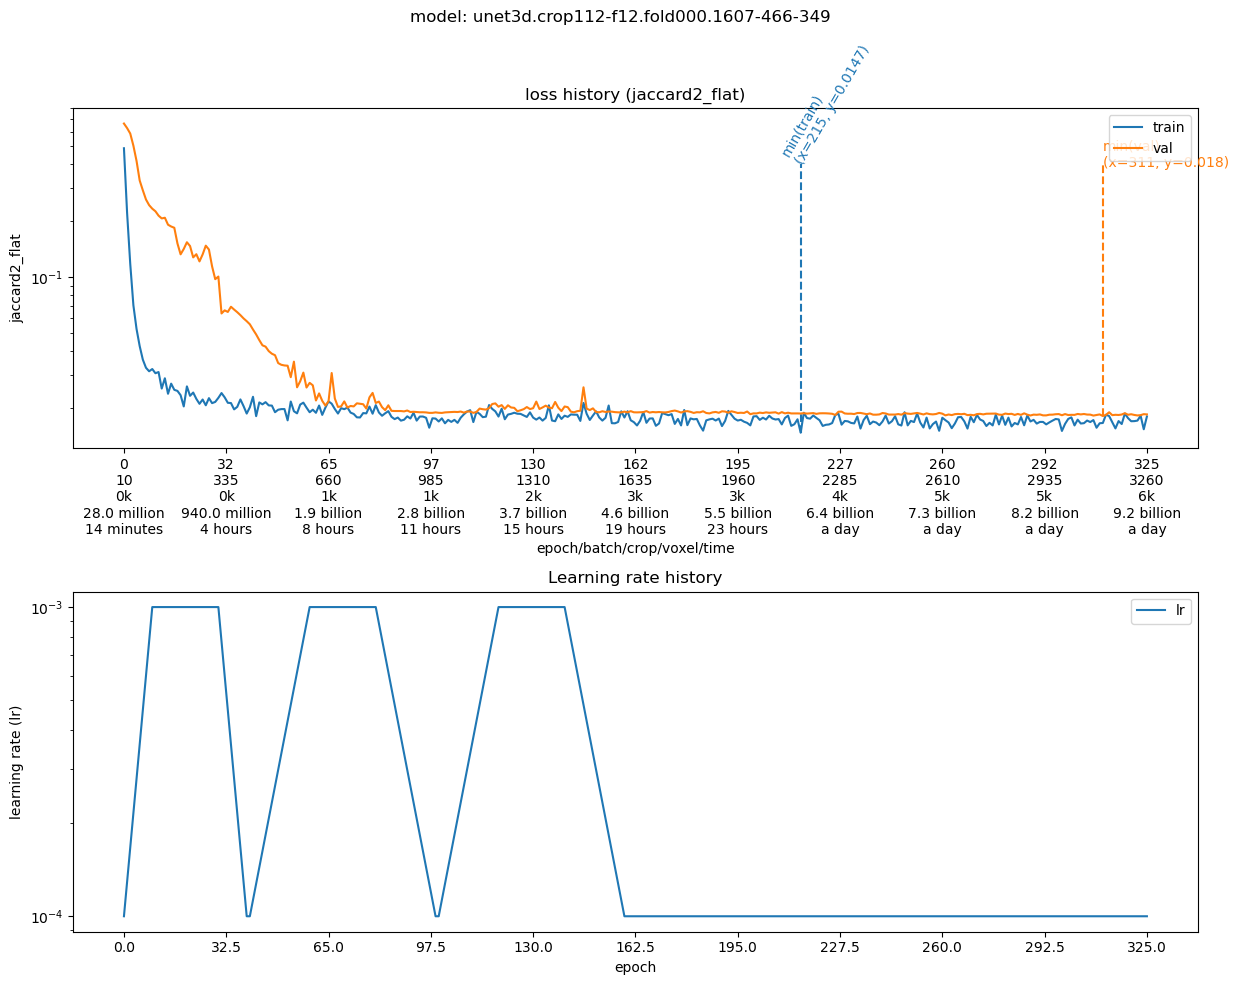

In [59]:
fig, axs = plt.subplots(nrows := 2, ncols := 1, figsize=(2.5 * (sz := 5), nrows * sz), dpi=100)
fig.set_tight_layout(True)

hist_display = viz.TrainingHistoryDisplay(
    history_cb.history, 
    model_name=tomo2seg_model.name,
    loss_name=model.loss.__name__,
    x_axis_mode=(
        "epoch", 
        "batch",
        "crop", 
        "voxel",
        "time",
    ),
).plot(
    axs, 
    with_lr=True,
    metrics=(
        "loss", 
#         "jaccard2.class_idx=0",
#         "jaccard2.class_idx=1",
#         "jaccard2.class_idx=2",
    ),
)

axs[0].set_yscale("log")
axs[-1].set_yscale("log")

viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["loss"][0])
viz.mark_min_values(hist_display.axs_metrics_[0], hist_display.plots_["val_loss"][0], txt_kwargs=dict(rotation=0))

hist_display.fig_.savefig(
    tomo2seg_model.model_path / (hist_display.title + ".png"),
    format='png',
)
# plt.close()

In [60]:
history_cb.dataframe.to_csv(history_cb.csv_path, index=True)

In [61]:
model.save(tomo2seg_model.model_path)

INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/data/models/unet3d/unet3d.crop112-f12.fold000.1607-466-349/assets


In [62]:
this_nb_name = "train-03.ipynb"
import os
this_dir = os.getcwd()
logger.warning(f"{this_nb_name=} {this_dir=}")

os.system(f"jupyter nbconvert {this_dir}/{this_nb_name} --output-dir {str(tomo2seg_model.model_path)} --to html")

this_nb_name='train-03.ipynb' this_dir='/home/users/jcasagrande/projects/tomo2seg/nbs'



0